In [94]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import glob
import os
import uns
import pandas as pd
folder = '/home/chrisv/code/fcn_train_log'
filepattern = 'predictions_*'
files = glob.glob(os.path.join(folder, filepattern))

In [95]:
tr = pd.read_msgpack('trainvalidate.bin')


In [96]:
def ndice(pred_batch,label_batch,sh=(416,576)):
      n_batch = pred_batch.shape[0]
      preds = pred_batch.reshape([n_batch,sh[0],sh[1]])
      labels = label_batch.reshape([n_batch,sh[0],sh[1]])
      denoms = np.sum(preds,axis=(1,2)) + np.sum(labels,axis=(1,2))
      cap = np.logical_and(preds, labels)
      numerators = 2*np.sum(cap, axis=(1,2))
      zero_denoms = np.where(denoms ==0)
      nonzero_denoms = np.where (denoms !=0)
      result = np.empty(denoms.shape)
      result[zero_denoms] = 1
      result[nonzero_denoms] = np.divide(numerators[nonzero_denoms],denoms[nonzero_denoms])
      return result

In [98]:
idxpred = 0
idxmask = 1

for f in files:
    print(f, ": ", np.load(f).shape)

/home/chrisv/code/fcn_train_log/predictions_chunk_1.npy :  (4, 2, 10, 416, 576)
/home/chrisv/code/fcn_train_log/predictions_chunk_11.npy :  (4, 2, 10, 416, 576)
/home/chrisv/code/fcn_train_log/predictions_chunk_10.npy :  (4, 2, 10, 416, 576)
/home/chrisv/code/fcn_train_log/predictions_chunk_7.npy :  (4, 2, 10, 416, 576)
/home/chrisv/code/fcn_train_log/predictions_chunk_2.npy :  (4, 2, 10, 416, 576)
/home/chrisv/code/fcn_train_log/predictions_chunk_12.npy :  (4, 2, 10, 416, 576)
/home/chrisv/code/fcn_train_log/predictions_chunk_6.npy :  (4, 2, 10, 416, 576)
/home/chrisv/code/fcn_train_log/predictions_chunk_8.npy :  (4, 2, 10, 416, 576)
/home/chrisv/code/fcn_train_log/predictions_chunk_4.npy :  (4, 2, 10, 416, 576)
/home/chrisv/code/fcn_train_log/predictions_chunk_9.npy :  (4, 2, 10, 416, 576)
/home/chrisv/code/fcn_train_log/predictions_chunk_5.npy :  (4, 2, 10, 416, 576)
/home/chrisv/code/fcn_train_log/predictions_chunk_0.npy :  (2, 2, 10, 416, 576)
/home/chrisv/code/fcn_train_log/predi

In [123]:
strange_data = np.concatenate([np.load(f) for f in files], axis=0)

In [124]:
data = np.reshape(np.transpose(strange_data,(0,2,1,3,4)), (-1,2,416,576))

In [87]:
# Pixel count cutoff
# convex hull or shape normalization
# softmax output (not predictions)


(4, 20, 416, 576)

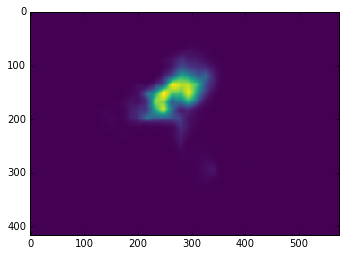

In [121]:
plt.imshow(data[5,0,:,:], cmap=plt.cm.viridis, interpolation='nearest')

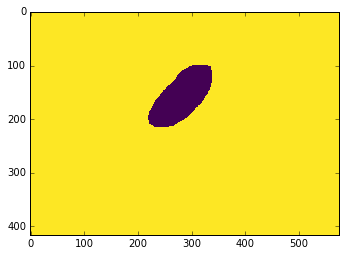

In [137]:
plt.imshow(data[5,1,:,:], cmap=plt.cm.viridis, interpolation='nearest')

In [7]:
score = ndice(data[:,idxpred,:,:], data[:,idxmask,:,:])

0.42999999999999999

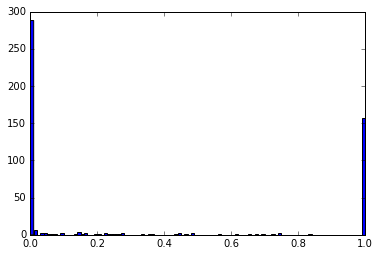

In [8]:
plt.hist(score, bins=100)
np.mean(score>0)

Why so many zero scores?

In [9]:
indices = np.argwhere(score == 0)

for i in indices:
    print('{i}: {predpix}/{maskpix}'.format(i=i,
                                            maskpix = np.sum(data[i,idxmask,:,:]),
                                            predpix = np.sum(data[i,idxpred,:,:])))


[0]: 0/299
[2]: 360/2018
[3]: 0/1379
[5]: 0/6518
[9]: 0/6944
[10]: 0/4192
[11]: 0/3025
[12]: 6091/22
[13]: 0/3656
[14]: 59/308
[16]: 0/6387
[17]: 5702/0
[18]: 0/9617
[20]: 4843/0
[21]: 272/0
[22]: 0/3796
[25]: 6959/0
[29]: 5020/0
[30]: 4546/0
[35]: 8009/0
[36]: 6917/0
[38]: 6276/0
[40]: 1149/81
[41]: 5818/143
[42]: 8705/0
[44]: 5103/0
[45]: 7621/0
[46]: 6827/7488
[47]: 8788/0
[49]: 9471/0
[50]: 1951/0
[52]: 80/0
[54]: 0/1112
[55]: 5786/0
[57]: 4670/0
[60]: 2312/0
[61]: 449/0
[62]: 0/61
[63]: 1635/0
[66]: 8676/0
[68]: 8159/0
[72]: 0/4002
[74]: 2198/0
[78]: 6183/0
[79]: 10792/0
[81]: 0/817
[82]: 5382/0
[83]: 6376/0
[84]: 7389/0
[85]: 7932/0
[86]: 0/7350
[87]: 5632/0
[90]: 0/4987
[92]: 3596/424
[94]: 166/0
[95]: 0/6475
[98]: 7023/0
[100]: 6336/0
[101]: 342/3869
[102]: 23/105
[103]: 3534/0
[105]: 5265/0
[107]: 6267/0
[108]: 0/4597
[110]: 0/4944
[111]: 6432/0
[112]: 3399/1657
[113]: 436/0
[114]: 8458/0
[115]: 0/6203
[116]: 6095/0
[117]: 7185/6524
[119]: 13076/0
[121]: 2909/0
[123]: 0/47
[12

In [126]:
indices = np.argwhere(np.logical_and(score>0.6, score<1)).flatten()

print(indices[:10])
batch = uns.batch(tr[tr['validate']].iloc[indices[:10]])

[  7  88 166 279 318 375 392 498]


In [11]:
tr[tr['validate']].iloc[indices[:10]]

,centcol,centrow,contH,contW,contour,contxmax,contxmin,contymax,contymin,hasmask,...,svdx1,svdy0,svdy1,unitcontour,sv0,sv1,sv2,sv3,train,validate
56,0.525207,0.205669,0.112078,0.150055,"[[162.001960784, 162.002231227, 160.175111361,...",0.279314,0.129259,0.584486,0.472409,True,...,0.011520,0.015190,0.246512,"[[0.0736452229359, 0.0736456892166, 0.07049548...",-0.400658,-0.058990,0.015420,0.043366,False,True
412,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True
772,0.663322,0.253193,0.186214,0.232765,"[[218.001960784, 218.001999498, 214.889314298,...",0.375866,0.143100,0.762072,0.575859,True,...,0.134948,0.184672,0.369514,"[[0.122672675228, 0.122672741976, 0.1173060433...",-0.662145,-0.039831,0.039133,0.033555,False,True
1266,0.550517,0.306434,0.187938,0.215539,"[[239.001960784, 237.925789717, 234.024820246,...",0.412072,0.196533,0.646555,0.458616,True,...,0.187830,0.257426,0.311084,"[[0.105638826357, 0.103783359, 0.0970575495667...",-0.608764,0.067207,0.027628,0.061462,False,True
1483,0.702973,0.406429,0.137939,0.215729,"[[298.001960784, 298.116018562, 294.0811317, 2...",0.513993,0.298264,0.770694,0.632755,True,...,0.082459,0.144264,0.260882,"[[0.107367276674, 0.107563928016, 0.1006072265...",-0.550337,-0.013145,-0.020452,-0.008133,False,True
1778,0.548681,0.209298,0.153455,0.258627,"[[198.001960784, 197.076271617, 191.21884847, ...",0.341383,0.082756,0.625865,0.472410,True,...,0.087017,0.163451,0.288425,"[[0.132084395002, 0.130488379196, 0.1203893737...",-0.637512,0.016726,-0.061397,0.004697,False,True
1883,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True
2498,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True


In [129]:
def plot_pred_mask(idx, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(8,6))    
    ax.imshow(data[idx,idxpred,:,:], alpha=0.5, cmap=plt.cm.plasma)
    ax.imshow(data[idx,idxmask,:,:], alpha=0.5, cmap=plt.cm.gray)
    ax.set_title(score[idx])  

[  7  88 166 279 318]


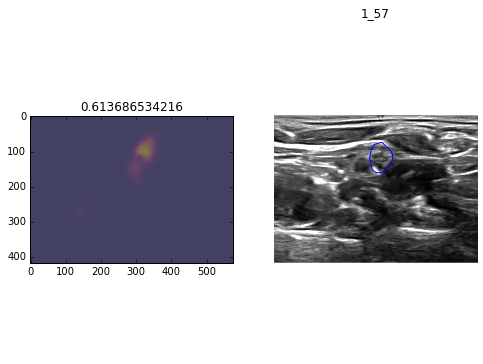

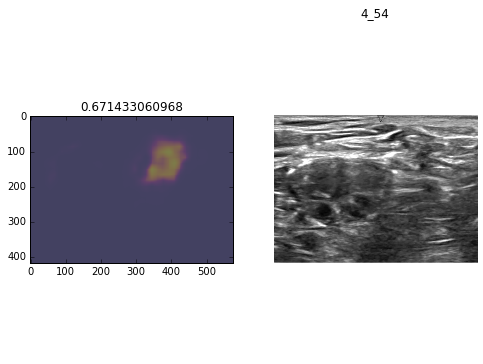

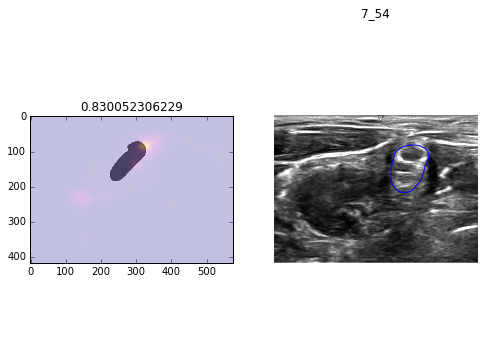

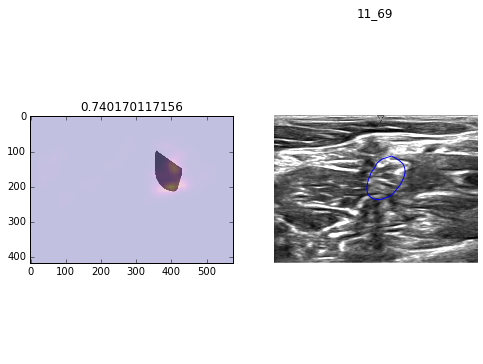

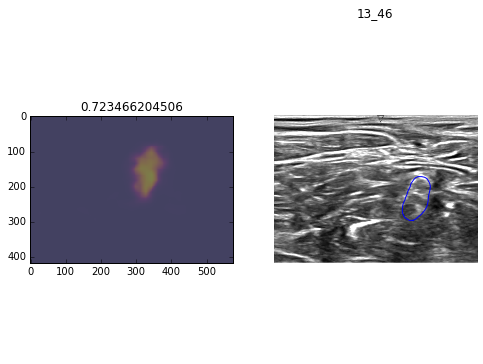

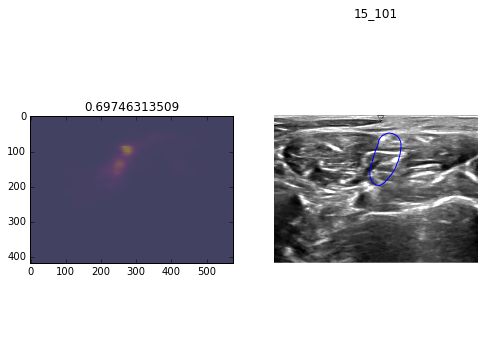

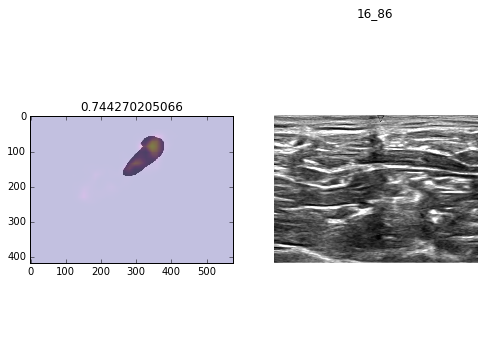

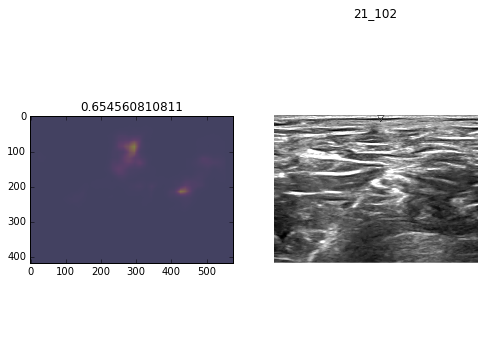

In [130]:

indices = np.argwhere(np.logical_and(score>0.6, score<1)).flatten()

print(indices[:5])
batch = uns.batch(tr[tr['validate']].iloc[indices[:10]])

for i,j in enumerate(indices[:10]):
    imgpair = batch.pop(0)
    fig, ax = plt.subplots(1,2, figsize=(8,6))
    plot_pred_mask(j, ax[0])
    imgpair.plot(ax=ax[1])
    
    

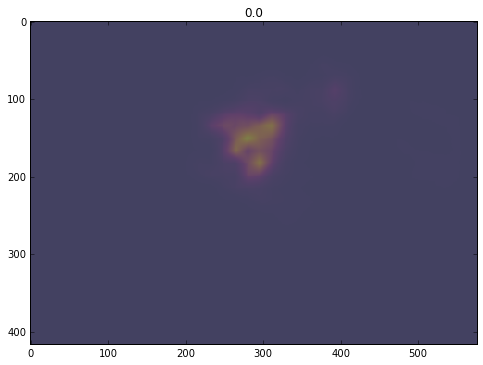

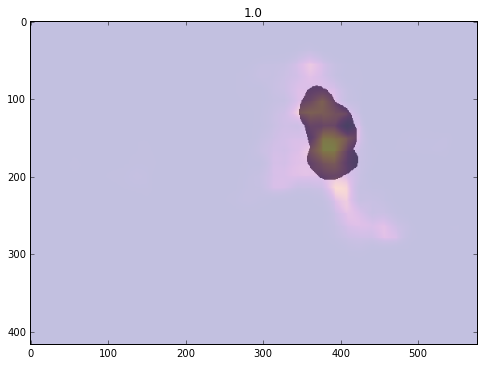

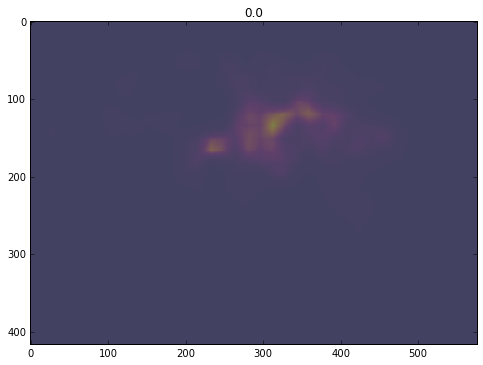

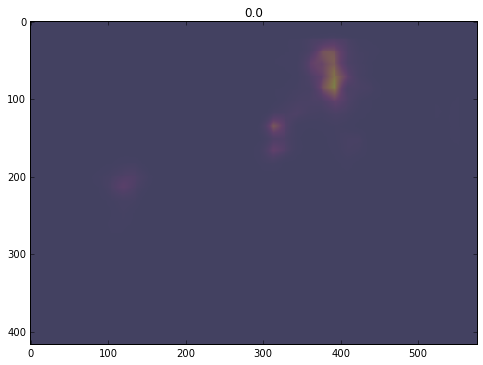

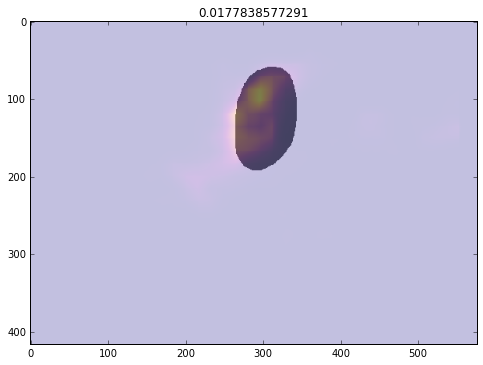

In [131]:
for i in range(5):
    plot_pred_mask(i)

What do the masks in the bottleneck files look like?

In [132]:
indices = [6,7]

1_57.btl


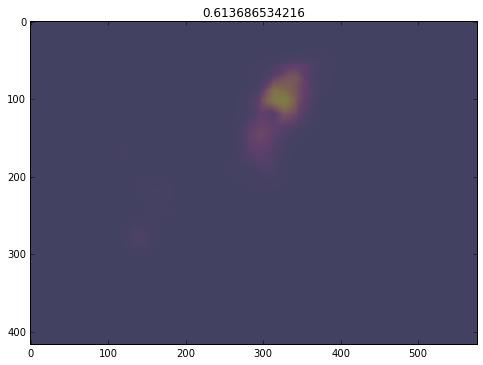

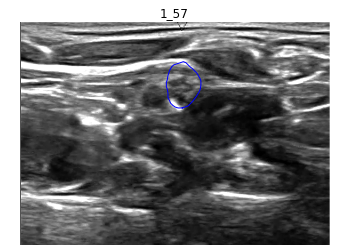

In [134]:
batch = uns.batch(tr[tr['validate']].iloc[indices])

imgpair = batch.pop(0)
print(imgpair.bottlefile)
i = indices.pop(0)
plot_pred_mask(i)
imgpair.plot()
record = np.fromfile('../bottleneck_files/' + imgpair.bottlefile, dtype=np.float32)

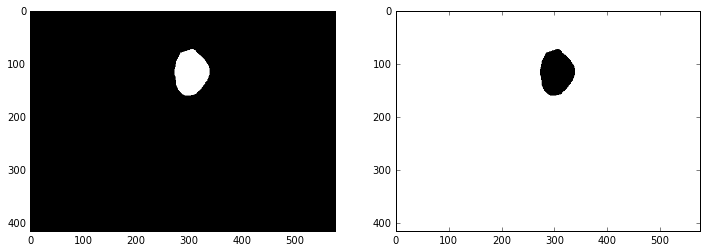

In [135]:
fc6dim = 13, 18, 4096
pooldim = 26, 36, 512
maskdim = 416, 576, 2 

Nfc6 = np.prod(fc6dim)
Npool = np.prod(pooldim)
Nmask = np.prod(maskdim)
#print(record.shape, Nfc6 + Npool + Nmask)

fc6 = record[:Nfc6].reshape(fc6dim)
pool = record[Nfc6:Nfc6+Npool].reshape(pooldim)
mask = np.reshape(record[Nfc6+Npool:], maskdim)

fig,ax = plt.subplots(1,2,figsize=(12,4))
ax[0].imshow(mask[:,:,0], cmap=plt.cm.gray)
ax[1].imshow(mask[:,:,1], cmap=plt.cm.gray)

0


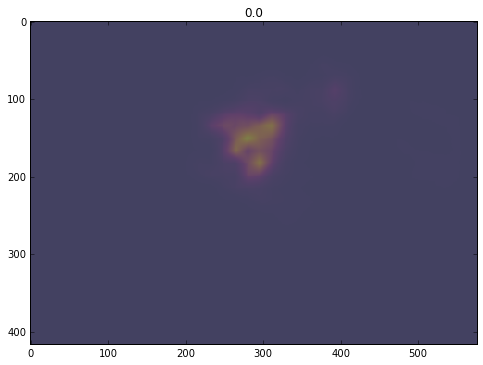

In [136]:
j = np.argmax(np.sum(np.logical_and(mask[:,:,0]>0, data[:,idxmask,:,:]), axis=(2,1)))

plot_pred_mask(j)
print(j)